In [1]:
# importing required libraries
import warnings

warnings.filterwarnings(action='ignore')

import matplotlib.pyplot as plt
import os
import glob

import pandas as pd
import random
import numpy as np

import imageio
import torch
import torch.nn as nn
import torch.nn.functional as F

from tqdm import tqdm
from PIL import Image
from sklearn.model_selection import train_test_split


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print('Training on ',device)

Training on  cpu


In [2]:
dataset_path = 'C:\\Users\\petka\\Desktop\\ITMO STUDY\\3-rd Semester\\Advanced Machine Learning Technologies\\lfw-deepfunneled'
attrib_path = 'lfw_attributes.txt'

In [3]:
dataset = list()
for path in glob.iglob(os.path.join(dataset_path, "**", "*.jpg")):
    person = path.split('\\')[-2]
    dataset.append({'person': person,
                    'path': path})
dataset = pd.DataFrame(dataset)
dataset = dataset.groupby('person').filter(lambda x: len(x) < 25)
dataset.head()

,person,path
0,Aaron_Eckhart,C:\Users\petka\Desktop\ITMO STUDY\3-rd Semeste...
1,Aaron_Guiel,C:\Users\petka\Desktop\ITMO STUDY\3-rd Semeste...
2,Aaron_Patterson,C:\Users\petka\Desktop\ITMO STUDY\3-rd Semeste...
3,Aaron_Peirsol,C:\Users\petka\Desktop\ITMO STUDY\3-rd Semeste...
4,Aaron_Peirsol,C:\Users\petka\Desktop\ITMO STUDY\3-rd Semeste...


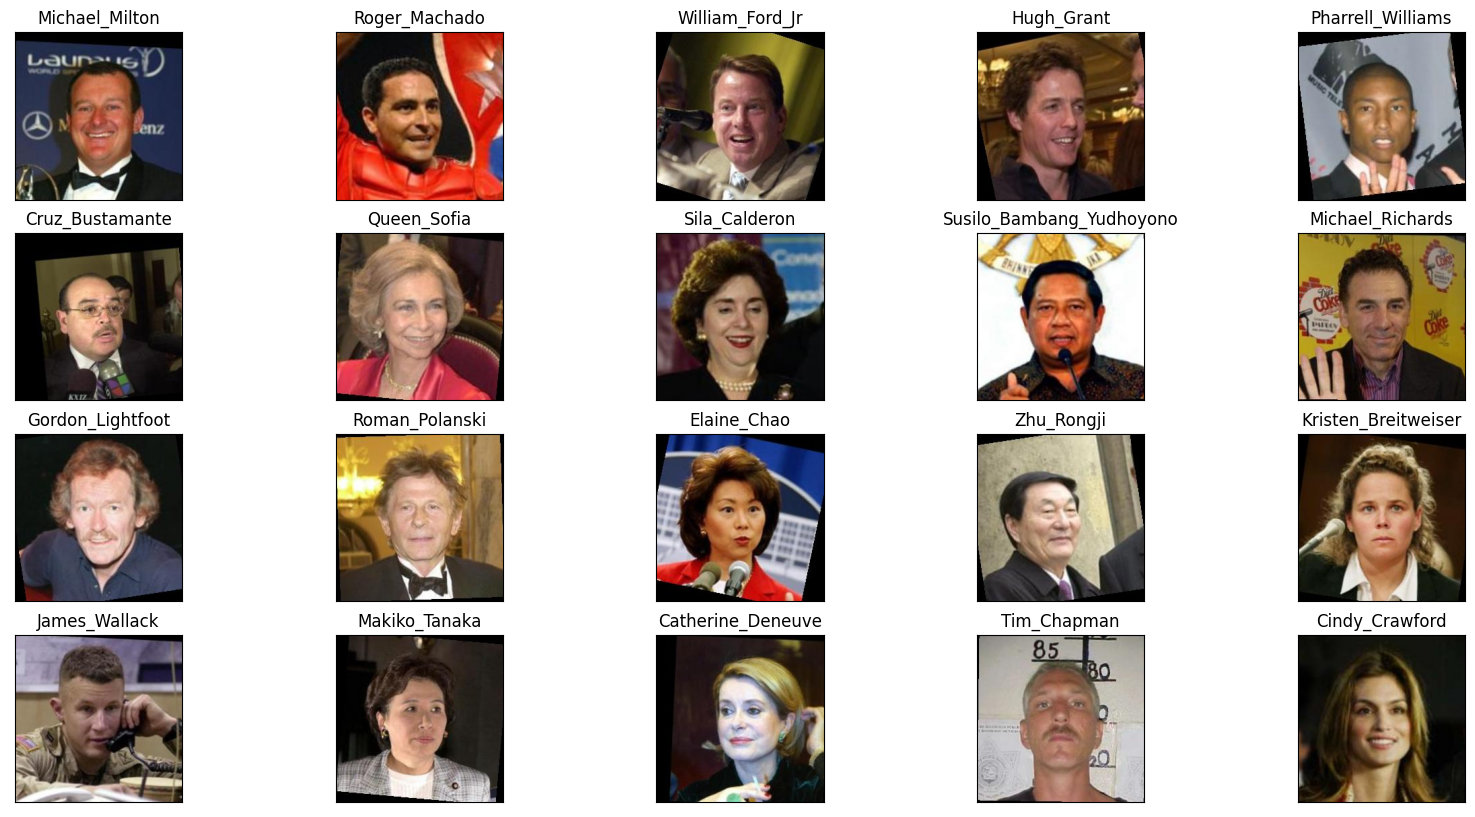

In [5]:
plt.figure(figsize=(20, 10))
for i in range(20):
    idx = random.randint(0, len(dataset))
    image = plt.imread(dataset.path.iloc[idx])
    plt.subplot(4, 5, i + 1)
    plt.imshow(image)
    plt.title(dataset.person.iloc[idx])
    plt.xticks([])
    plt.yticks([])

In [6]:
def fetch_dataset(dx=80,dy=80, dimx=45,dimy=45):
    
    df_attrs = pd.read_csv(attrib_path, sep='\t', skiprows=1,) 
    df_attrs = pd.DataFrame(df_attrs.iloc[:,:-1].values, columns = df_attrs.columns[1:])
    
    photo_ids = []
    for dirpath, dirnames, filenames in os.walk(dataset_path):
        for fname in filenames:
            if fname.endswith(".jpg"):
                fpath = os.path.join(dirpath,fname)
                photo_id = fname[:-4].replace('_',' ').split()
                person_id = ' '.join(photo_id[:-1])
                photo_number = int(photo_id[-1])
                photo_ids.append({'person':person_id,'imagenum':photo_number,'photo_path':fpath})

    photo_ids = pd.DataFrame(photo_ids)
    df = pd.merge(df_attrs,photo_ids,on=('person','imagenum'))

    assert len(df)==len(df_attrs),"lost some data when merging dataframes"
    
    all_photos = df['photo_path'].apply(imageio.imread)\
                                .apply(lambda img:img[dy:-dy,dx:-dx])\
                                .apply(lambda img: np.array(Image.fromarray(img).resize([dimx,dimy])) )

    all_photos = np.stack(all_photos.values).astype('uint8')
    all_attrs = df.drop(["photo_path","person","imagenum"],axis=1)
    
    return all_photos,all_attrs

In [7]:
data, attribs = fetch_dataset()
print(f'data shape: {data.shape}, attribs shape: {attribs.shape}')

data shape: (13143, 45, 45, 3), attribs shape: (13143, 73)


In [ ]:
attribs.columns

In [8]:
#45,45
IMAGE_H = data.shape[1]
IMAGE_W = data.shape[2]

N_CHANNELS = 3

In [9]:
data = np.array(data / 255, dtype='float32')
X_train, X_val = train_test_split(data, test_size=0.2, random_state=42)

X_train = torch.FloatTensor(X_train)
X_val = torch.FloatTensor(X_val)

In [10]:
X_train.shape

torch.Size([10514, 45, 45, 3])

## VAE model building

In [11]:
dim_z = 256

In [18]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        
        self.fc1 = nn.Linear(45 * 45 * 3, 1500)
        self.fc1_1 = nn.Linear(1500, 1500)

        self.fc2_1 = nn.Linear(1500, dim_z)
        self.fc2_2 = nn.Linear(1500, dim_z)

        self.fc3 = nn.Linear(dim_z, 1500)
        self.fc3_1 = nn.Linear(1500, 1500)

        self.fc_4 = nn.Linear(1500, 45 * 45 * 3)
        self.relu = nn.LeakyReLU()

    def encode(self, x):
        x = self.relu(self.fc1(x))
        return self.fc2_1(x), self.fc2_2(x)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 *logvar)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu)

    def decode(self, z):
        z = self.relu(self.fc3(z)) #1500
        return torch.sigmoid(self.fc_4(z))

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        z = self.decode(z)
        return z, mu, logvar

def loss_vae_fn(x, recon_x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

In [19]:
model_vae = VAE().to(device)

In [14]:
def get_batch(data, batch_size = 64):
    total_len = data.shape[0]
    for i in range(0, total_len, batch_size):
        yield data[i: min(i + batch_size, total_len)]

def plot_gallery(images, h, w, n_rows=3, n_cols=6, with_title=False, titles=[]):
    plt.figure(figsize=(1.5 * n_cols, 1.7 * n_rows))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_rows * n_cols):
        plt.subplot(n_rows, n_cols, i + 1)
        try:
            plt.imshow(images[i].reshape((h, w, 3)),
                       cmap=plt.cm.gray,
                       vmin=-1, vmax=1,
                       interpolation='nearest')
            if with_title:
                plt.title(titles[i])
            plt.xticks(())
            plt.yticks(())
        except:
            pass

In [15]:
def fit_epoch_vae(model, train_x, optimizer, batch_size, is_cnn=False):
    running_loss = 0.0
    processed_data = 0

    for inputs in get_batch(train_x, batch_size):
        inputs = inputs.view(-1, 45 * 45 * 3)
        inputs = inputs.to(device)
        optimizer.zero_grad()

        decoded,mu,logvar, = model(inputs)
        outputs = decoded.view(-1, 45 * 45 * 3)
        outputs = outputs.to(device)

        loss = loss_vae_fn(inputs, outputs, mu, logvar)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.shape[0]
        processed_data += inputs.shape[0]

    train_loss = running_loss / processed_data
    return train_loss

def eval_epoch_vae(model, x_val, batch_size):
    running_loss = 0.0
    processed_data = 0
    model.eval()

    for inputs in get_batch(x_val, batch_size=batch_size):
        inputs = inputs.view(-1, 45 * 45 * 3)
        inputs = inputs.to(device)

        with torch.set_grad_enabled(False):
            decoded, mu, logvar = model(inputs)
            outputs = decoded.view(-1, 45 * 45 * 3)
            loss = loss_vae_fn(inputs, outputs, mu, logvar)
            running_loss += loss.item() * inputs.shape[0]
            processed_data += inputs.shape[0]

    val_loss = running_loss / processed_data

    #draw
    with torch.set_grad_enabled(False):
        pic = x_val[3]
        pic_input = pic.view(-1, 45 * 45 * 3)
        pic_input = pic_input.to(device)
        decoded, mu, logvar = model(inputs)
        pic_output = decoded[0].view(-1, 45 * 45 * 3).squeeze()
        pic_output = pic_output.to("cpu")
        pic_input = pic_input.to("cpu")
        plot_gallery([pic_input, pic_output], 45, 45, 1, 2)

    return val_loss

def train_vae(train_x, val_x, model, epochs=10, batch_size=32, lr=0.001):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} val_loss: {val_loss:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        for epoch in range(epochs):
            train_loss = fit_epoch_vae(model, train_x, optimizer, batch_size)
            val_loss = eval_epoch_vae(model, val_x, batch_size)
            print("loss: ", train_loss)

            history.append((train_loss,val_loss))

            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss, val_loss=val_loss))

    return history

## Model training

epoch:   2%|▏         | 1/50 [00:28<23:30, 28.79s/it]

loss:  515588.93759065296

Epoch 001 train_loss: 515588.9376 val_loss: 502512.5632


epoch:   4%|▍         | 2/50 [00:58<23:28, 29.34s/it]

loss:  501528.6567448759

Epoch 002 train_loss: 501528.6567 val_loss: 493273.4257


epoch:   6%|▌         | 3/50 [01:26<22:24, 28.60s/it]

loss:  496449.9689253614

Epoch 003 train_loss: 496449.9689 val_loss: 491994.7849


epoch:   8%|▊         | 4/50 [01:53<21:22, 27.89s/it]

loss:  494706.4726703681

Epoch 004 train_loss: 494706.4727 val_loss: 489762.3679


epoch:  10%|█         | 5/50 [02:20<20:42, 27.60s/it]

loss:  493720.26111761696

Epoch 005 train_loss: 493720.2611 val_loss: 488725.2817


epoch:  12%|█▏        | 6/50 [02:45<19:38, 26.78s/it]

loss:  492701.751123502

Epoch 006 train_loss: 492701.7511 val_loss: 487895.3202


epoch:  14%|█▍        | 7/50 [03:14<19:48, 27.63s/it]

loss:  491743.3475247289

Epoch 007 train_loss: 491743.3475 val_loss: 487004.4312


epoch:  16%|█▌        | 8/50 [03:40<18:59, 27.13s/it]

loss:  491123.54145514313

Epoch 008 train_loss: 491123.5415 val_loss: 486834.6520


epoch:  18%|█▊        | 9/50 [04:11<19:16, 28.22s/it]

loss:  490700.3837309183

Epoch 009 train_loss: 490700.3837 val_loss: 486545.2093


epoch:  20%|██        | 10/50 [04:37<18:27, 27.69s/it]

loss:  490175.75308814435

Epoch 010 train_loss: 490175.7531 val_loss: 485357.2793


epoch:  22%|██▏       | 11/50 [05:03<17:37, 27.10s/it]

loss:  489808.1722376118

Epoch 011 train_loss: 489808.1722 val_loss: 485461.4873


epoch:  24%|██▍       | 12/50 [05:29<16:57, 26.78s/it]

loss:  489316.5034834506

Epoch 012 train_loss: 489316.5035 val_loss: 485653.7534


epoch:  26%|██▌       | 13/50 [05:56<16:27, 26.70s/it]

loss:  488958.27503210003

Epoch 013 train_loss: 488958.2750 val_loss: 484199.1823


epoch:  28%|██▊       | 14/50 [06:21<15:45, 26.25s/it]

loss:  488493.48888386914

Epoch 014 train_loss: 488493.4889 val_loss: 484271.4113


epoch:  30%|███       | 15/50 [06:48<15:28, 26.52s/it]

loss:  488062.43698283244

Epoch 015 train_loss: 488062.4370 val_loss: 483125.4448


epoch:  32%|███▏      | 16/50 [07:14<14:53, 26.27s/it]

loss:  487482.176330369

Epoch 016 train_loss: 487482.1763 val_loss: 484381.0347


epoch:  34%|███▍      | 17/50 [07:39<14:17, 25.99s/it]

loss:  487442.6645558898

Epoch 017 train_loss: 487442.6646 val_loss: 482712.5946


epoch:  36%|███▌      | 18/50 [08:05<13:51, 25.98s/it]

loss:  486766.9638220468

Epoch 018 train_loss: 486766.9638 val_loss: 483747.6787


epoch:  38%|███▊      | 19/50 [08:30<13:16, 25.71s/it]

loss:  486549.09777885437

Epoch 019 train_loss: 486549.0978 val_loss: 481777.9260


epoch:  40%|████      | 20/50 [09:04<14:05, 28.20s/it]

loss:  486096.409124144

Epoch 020 train_loss: 486096.4091 val_loss: 481641.9714


epoch:  42%|████▏     | 21/50 [09:35<13:57, 28.86s/it]

loss:  485768.1846570644

Epoch 021 train_loss: 485768.1847 val_loss: 481708.4593


epoch:  44%|████▍     | 22/50 [10:01<13:07, 28.11s/it]

loss:  485478.4030221609

Epoch 022 train_loss: 485478.4030 val_loss: 481174.9018


epoch:  46%|████▌     | 23/50 [10:27<12:19, 27.37s/it]

loss:  485149.09395954205

Epoch 023 train_loss: 485149.0940 val_loss: 480532.0861


epoch:  48%|████▊     | 24/50 [10:52<11:34, 26.70s/it]

loss:  484785.60864680423

Epoch 024 train_loss: 484785.6086 val_loss: 479833.1638


epoch:  50%|█████     | 25/50 [11:17<10:56, 26.27s/it]

loss:  484514.8479527297

Epoch 025 train_loss: 484514.8480 val_loss: 479775.4267


epoch:  52%|█████▏    | 26/50 [11:43<10:31, 26.29s/it]

loss:  484205.19542693073

Epoch 026 train_loss: 484205.1954 val_loss: 479496.6031


epoch:  54%|█████▍    | 27/50 [12:09<09:57, 25.99s/it]

loss:  484056.38203674863

Epoch 027 train_loss: 484056.3820 val_loss: 479132.6283


epoch:  56%|█████▌    | 28/50 [12:35<09:31, 25.97s/it]

loss:  483870.1153387745

Epoch 028 train_loss: 483870.1153 val_loss: 478960.0080


epoch:  58%|█████▊    | 29/50 [13:00<09:02, 25.82s/it]

loss:  483600.8043531244

Epoch 029 train_loss: 483600.8044 val_loss: 478801.8569


epoch:  60%|██████    | 30/50 [13:26<08:38, 25.91s/it]

loss:  483483.19566470897

Epoch 030 train_loss: 483483.1957 val_loss: 478342.0917


epoch:  62%|██████▏   | 31/50 [13:54<08:25, 26.59s/it]

loss:  483267.49236880586

Epoch 031 train_loss: 483267.4924 val_loss: 478361.0248


epoch:  64%|██████▍   | 32/50 [14:21<07:57, 26.53s/it]

loss:  483137.5125442862

Epoch 032 train_loss: 483137.5125 val_loss: 478094.3994


epoch:  66%|██████▌   | 33/50 [14:46<07:24, 26.17s/it]

loss:  482871.31616921484

Epoch 033 train_loss: 482871.3162 val_loss: 478070.2708


epoch:  68%|██████▊   | 34/50 [15:12<06:58, 26.15s/it]

loss:  482785.23103124404

Epoch 034 train_loss: 482785.2310 val_loss: 477637.9486


epoch:  70%|███████   | 35/50 [15:40<06:40, 26.67s/it]

loss:  482522.2188257918

Epoch 035 train_loss: 482522.2188 val_loss: 479497.8204


epoch:  72%|███████▏  | 36/50 [16:06<06:11, 26.56s/it]

loss:  482440.9609568195

Epoch 036 train_loss: 482440.9610 val_loss: 477369.3255


epoch:  74%|███████▍  | 37/50 [16:32<05:42, 26.34s/it]

loss:  482226.80498769495

Epoch 037 train_loss: 482226.8050 val_loss: 477242.1884


epoch:  76%|███████▌  | 38/50 [16:58<05:13, 26.09s/it]

loss:  482134.12997699494

Epoch 038 train_loss: 482134.1300 val_loss: 477199.8097


epoch:  78%|███████▊  | 39/50 [17:23<04:43, 25.81s/it]

loss:  481959.83417051076

Epoch 039 train_loss: 481959.8342 val_loss: 477683.6775


epoch:  80%|████████  | 40/50 [17:48<04:16, 25.62s/it]

loss:  481842.69435692887

Epoch 040 train_loss: 481842.6944 val_loss: 476850.4321


epoch:  82%|████████▏ | 41/50 [18:13<03:48, 25.44s/it]

loss:  481721.9793816578

Epoch 041 train_loss: 481721.9794 val_loss: 476773.0042


epoch:  84%|████████▍ | 42/50 [18:38<03:22, 25.29s/it]

loss:  481612.28902534716

Epoch 042 train_loss: 481612.2890 val_loss: 476571.2842


epoch:  86%|████████▌ | 43/50 [19:03<02:56, 25.26s/it]

loss:  481484.11685609666

Epoch 043 train_loss: 481484.1169 val_loss: 476450.9287


epoch:  88%|████████▊ | 44/50 [19:28<02:31, 25.28s/it]

loss:  481401.0451332747

Epoch 044 train_loss: 481401.0451 val_loss: 476644.6422


epoch:  90%|█████████ | 45/50 [19:54<02:06, 25.29s/it]

loss:  481316.8232490608

Epoch 045 train_loss: 481316.8232 val_loss: 476553.0742


epoch:  92%|█████████▏| 46/50 [20:19<01:41, 25.33s/it]

loss:  481235.02515841974

Epoch 046 train_loss: 481235.0252 val_loss: 476908.6286


epoch:  94%|█████████▍| 47/50 [20:45<01:16, 25.39s/it]

loss:  481224.9142096253

Epoch 047 train_loss: 481224.9142 val_loss: 476131.3793


epoch:  96%|█████████▌| 48/50 [21:10<00:50, 25.43s/it]

loss:  481028.3206483617

Epoch 048 train_loss: 481028.3206 val_loss: 476149.7704


epoch:  98%|█████████▊| 49/50 [21:36<00:25, 25.53s/it]

loss:  480963.52871617605

Epoch 049 train_loss: 480963.5287 val_loss: 476961.7083


epoch: 100%|██████████| 50/50 [22:02<00:00, 26.45s/it]

loss:  480877.9254446452

Epoch 050 train_loss: 480877.9254 val_loss: 477636.8924


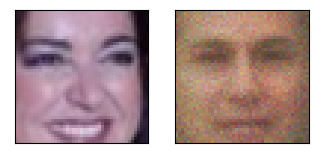

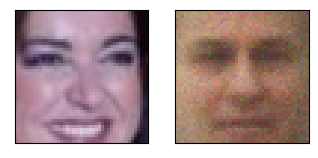

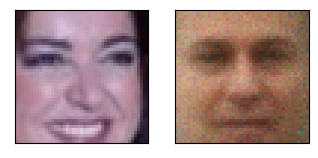

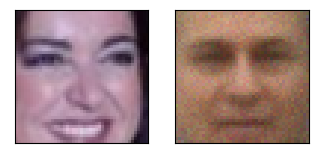

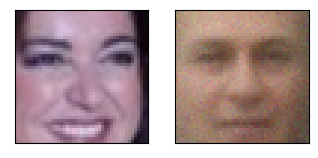

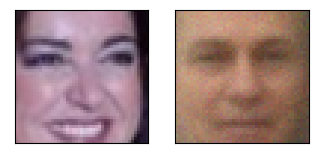

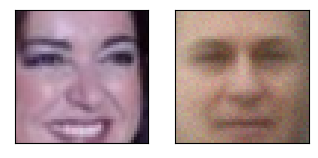

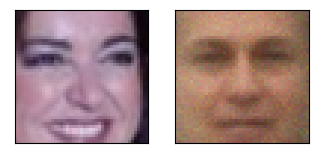

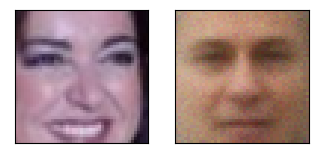

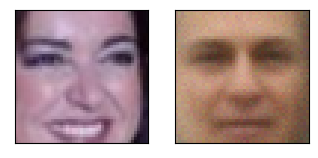

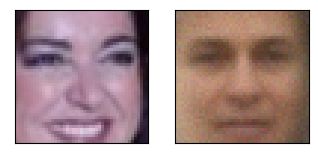

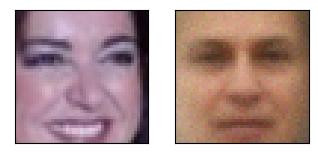

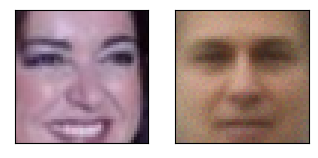

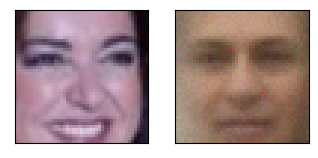

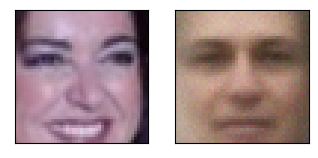

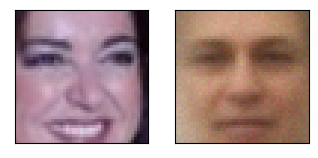

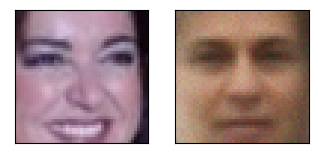

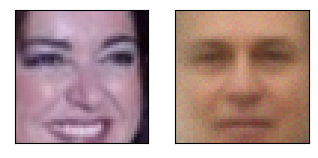

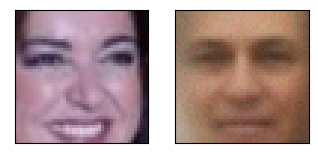

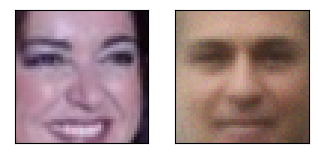

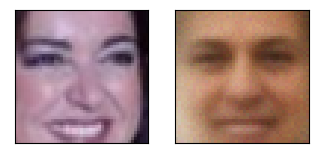

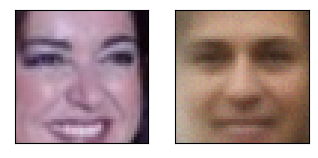

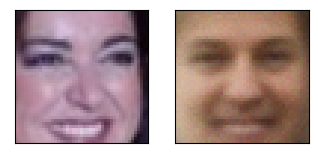

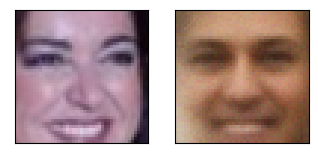

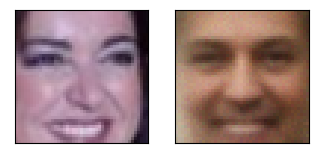

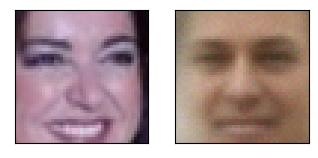

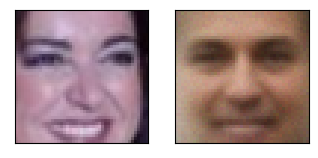

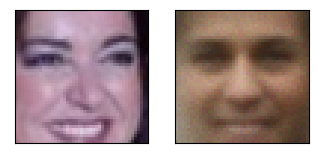

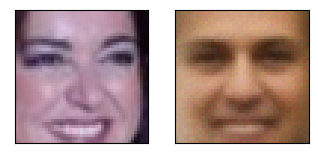

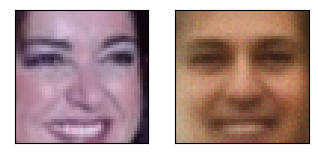

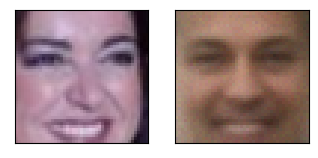

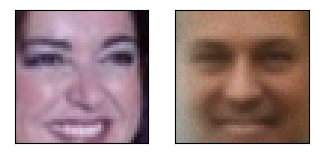

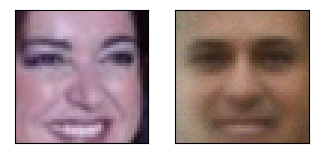

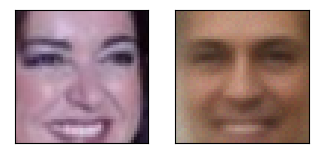

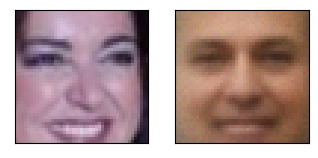

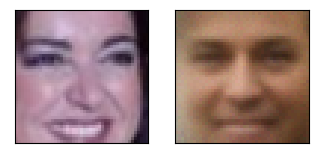

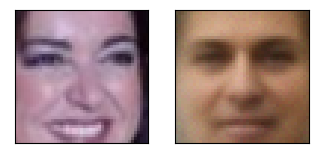

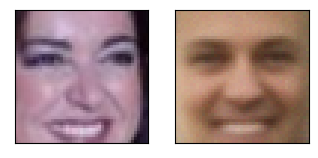

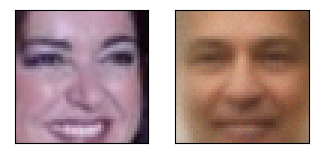

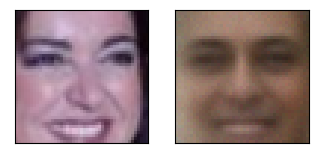

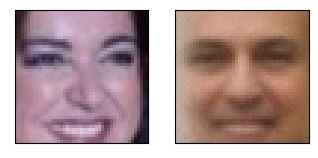

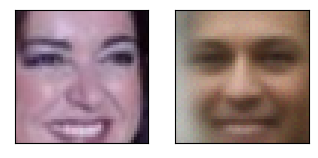

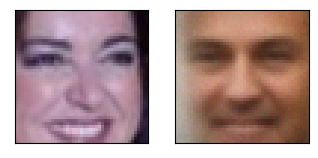

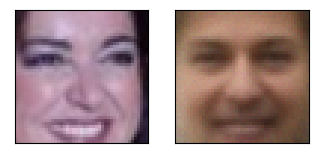

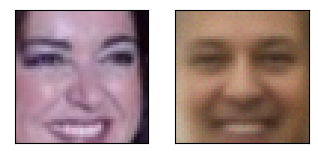

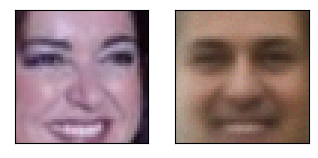

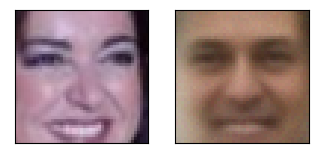

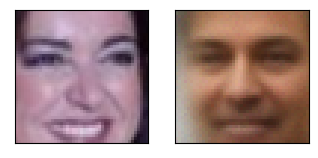

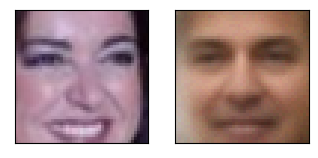

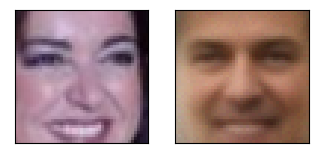

In [20]:
history_vae = train_vae(X_train, X_val, model_vae, epochs=50, batch_size=128, lr=0.0001)

## Train and val losses

[]

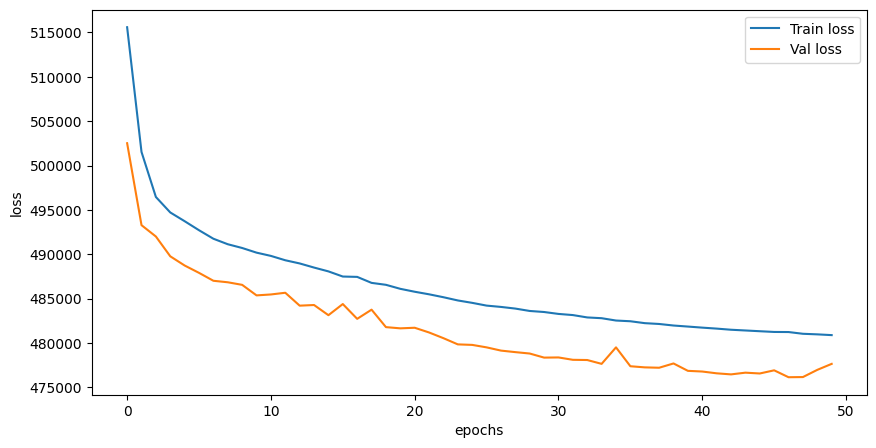

In [21]:
train_loss, val_loss = zip(*history_vae)
plt.figure(figsize=(10,5))
plt.plot(train_loss, label='Train loss')
plt.plot(val_loss, label='Val loss')
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.plot()

## Sampling

(25, 256)


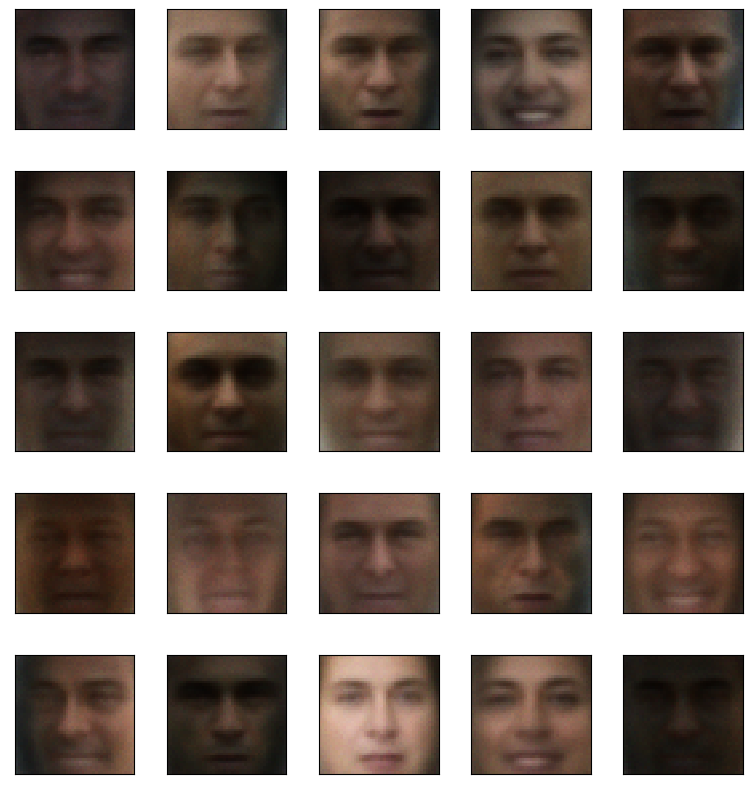

In [23]:
z = np.random.randn(25, dim_z)
print(z.shape)

with torch.no_grad():
    inputs = torch.FloatTensor(z)    
    inputs = inputs.to(device)
    model_vae.eval()
    output = model_vae.decode(inputs)
    plot_gallery(output.data.cpu().numpy(), IMAGE_H, IMAGE_W, n_rows=5, n_cols=5)

#### Preparing data with required features

In [29]:
# smile and NO smile data
smile_ids = attribs['Smiling'].sort_values(ascending=False).iloc[100:125].index.values
smile_data = data[smile_ids]

no_smile_ids = attribs['Smiling'].sort_values(ascending=True).head(25).index.values
no_smile_data = data[no_smile_ids]

# mustache data and NO mustache
mustache_ids = attribs['Mustache'].sort_values(ascending=False).head(25).index.values
mustache_data = data[mustache_ids]

no_mustache_ids = attribs['Mustache'].sort_values(ascending=True).head(25).index.values
no_mustache_data = data[no_mustache_ids]

# beard and NO beard data
beard_ids = attribs['No Beard'].sort_values(ascending=True).head(25).index.values
beard_data = data[beard_ids]

male = attribs[attribs['Male'] > 0]

no_beard_ids = male['No Beard'].sort_values(ascending=False).head(25).index.values
no_beard_data = data[no_beard_ids]


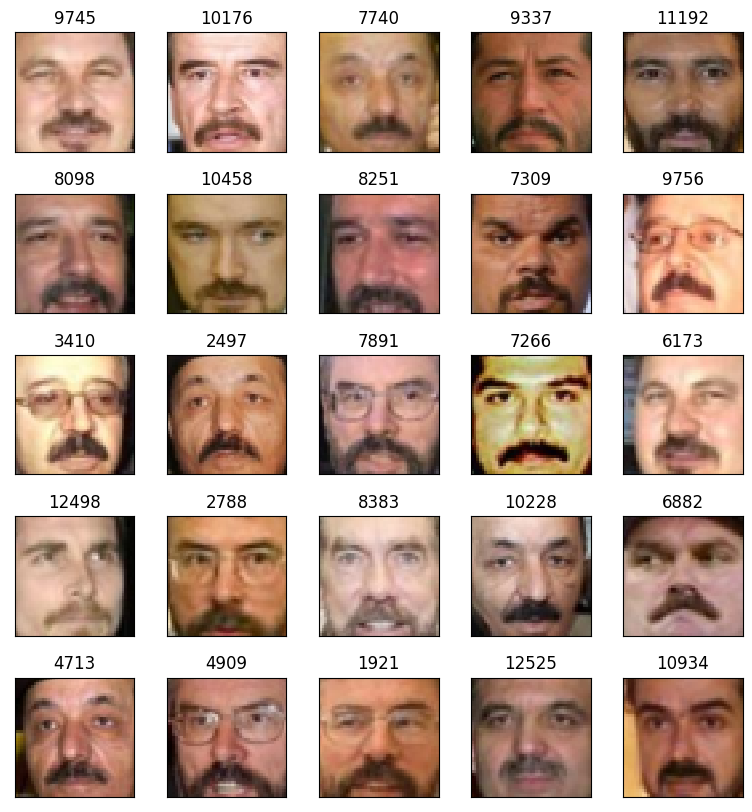

In [26]:
plot_gallery(mustache_data, IMAGE_H, IMAGE_W, n_rows=5, n_cols=5, with_title=True, titles=smile_ids)

#### Calculating latent space vector for selected images

In [27]:
def to_latent(pic):
    with torch.no_grad():
        inputs = torch.FloatTensor(pic.reshape(-1, 45 * 45 * 3))
        inputs = inputs.to(device)
        model_vae.eval()
        output = model_vae.encode(inputs)
        return output[0]

def from_latent(vec):
    with torch.no_grad():
        inputs = vec.to(device)
        model_vae.eval()
        output = model_vae.decode(inputs)
        return output

In [37]:
smile_latent = to_latent(smile_data).mean(axis=0)
no_smile_latent = to_latent(no_smile_data).mean(axis=0)

mustache_latent = to_latent(mustache_data).mean(axis=0)
no_mustache_latent = to_latent(no_mustache_data).mean(axis=0)
beard_latent = to_latent(beard_data).mean(axis=0)
no_beard_latent = to_latent(no_beard_data).mean(axis=0)

smile_vec = smile_latent - no_smile_latent
no_beard_vec = no_beard_latent - beard_latent
no_mustache_vec = no_mustache_latent - mustache_latent
shaving_vec = smile_vec + no_beard_vec # + no_mustache_vec


def make_me_smile_and_shave(ids):
    for id in ids:
        pic = data[id:id+1]

        latent_vec = to_latent(pic)

        latent_vec[0] += smile_vec
        pic_output = from_latent(latent_vec)
        pic_output = pic_output.view(-1, 45, 45, 3).cpu()
        plot_gallery([pic,pic_output], IMAGE_H, IMAGE_W, n_rows=1, n_cols=2)


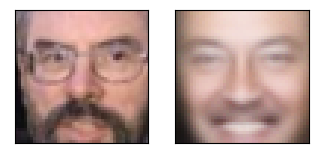

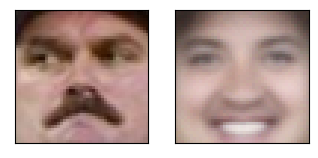

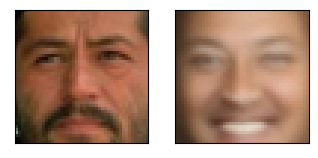

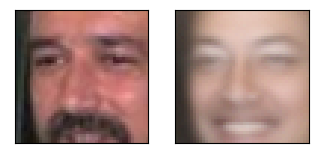

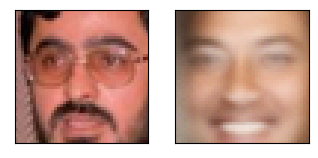

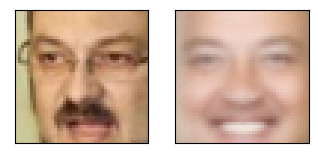

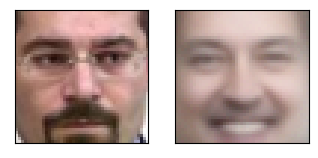

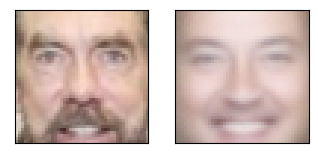

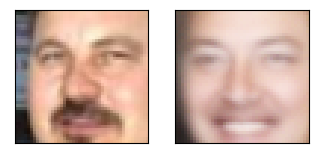

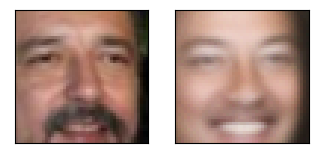

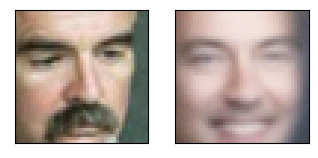

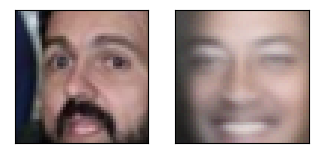

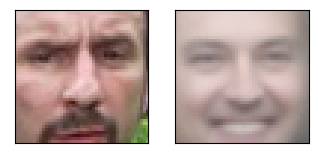

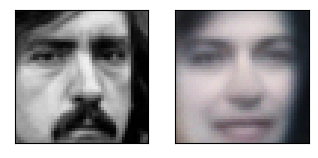

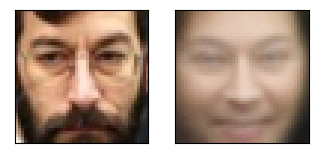

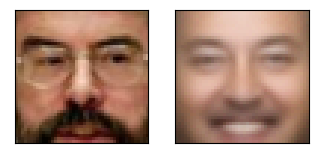

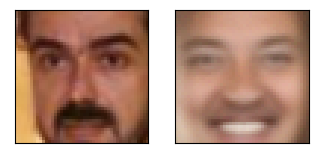

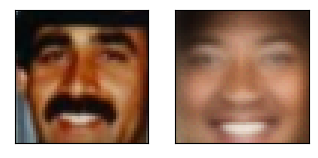

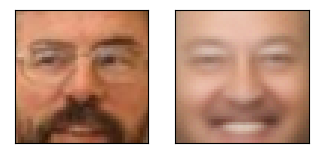

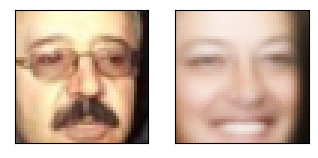

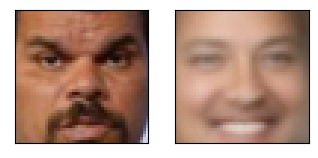

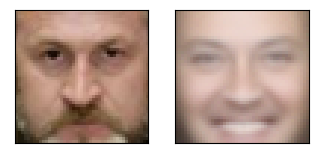

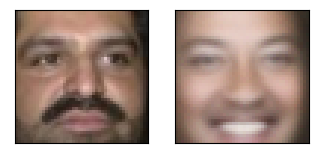

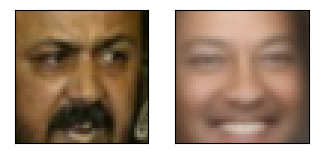

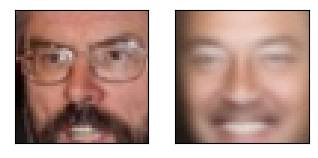

In [38]:
make_me_smile_and_shave(beard_ids)

## Applying smiling and shaving to unknown image

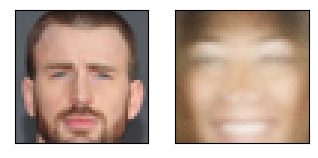

In [42]:
def cust_make_smile_and_shave(pic_path):
    dx, dy = 45, 45
    img = imageio.imread(pic_path)
    img = img[dy: -dy, dx: -dx]
    img = np.array(Image.fromarray(img).resize([dx, dy]))
    norm_img = np.array(img / 255, dtype='float32')
    norm_img = np.expand_dims(norm_img, axis=0)
    latent_vec = to_latent(norm_img)
    latent_vec[0] += shaving_vec
    pic_output = from_latent(latent_vec)
    pic_output = pic_output.view(-1,45,45,3).cpu()
    plot_gallery([norm_img, pic_output], IMAGE_H, IMAGE_W, n_rows=1, n_cols=2)

cust_make_smile_and_shave('chris evans.jpg')
